# Aramco Data Science intern home task


---

## Precode


In [1]:
try:
    get_ipython().run_line_magic("load_ext", "lab_black")
    # %load_ext lab_black
    %config InlineBackend.figure_format = 'retina'
except:
    print("Could not load lab_black")

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Could not load lab_black


In [2]:
df_coords = pd.read_csv("../data/meta.csv")
df_coords["group"] = df_coords["cat"].str[0]
df_coords

,cat,x,y,group
0,P1,190,190,P
1,P2,190,890,P
2,I1,890,190,I
3,I2,590,770,I
4,I3,670,510,I


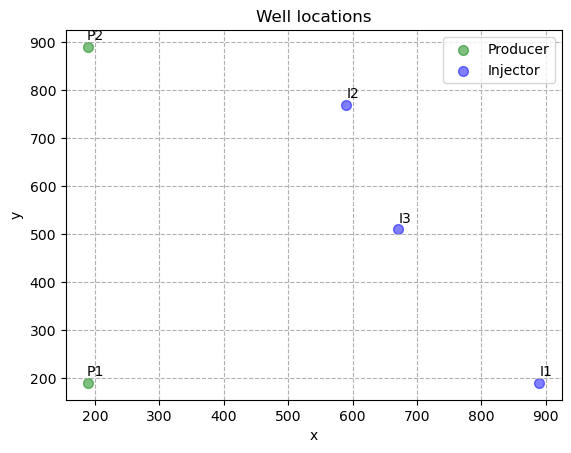

In [3]:
# create a dictionary that maps categories to colors
color_dict = {"P": "green", "I": "blue"}

# generate a scatter plot with color-coded points
for group, color in color_dict.items():
  df_cat = df_coords[df_coords["group"] == group]
  plt.scatter(df_cat["x"], df_cat["y"], s=50,
              alpha=0.5, color=color, label=group)

for i, row in df_coords.iterrows():
  plt.annotate(
      row["cat"],
      (row["x"], row["y"]),
      textcoords="offset points",
      xytext=(5, 5),
      ha="center",
      color="k",  # change the text color to red
  )

# add labels and legend
plt.title("Well locations")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(ls="--")
plt.legend(["Producer", "Injector"])

In [4]:
df = pd.read_csv("../data/data.csv")
df.head(3)

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef
0,P1,P,0,-0.001486,0.00000,-0.001486,2.000000e+07,1,19,0.42
1,P2,P,0,-0.001941,0.00000,-0.001941,2.000000e+07,1,19,0.42
2,I1,I,0,NaN,0.00255,0.002550,4.031142e+07,1,19,0.42


In [5]:
# define the colormap to use
cmap = plt.get_cmap("Set2")

coefs = sorted(df["coef"].unique())

# convert the coefs list to a numpy array
coefs = np.array(coefs)

# use isnan() to create a boolean array indicating which values are NaN
mask = np.isnan(coefs)

# use the boolean array to select only the non-NaN values
coefs = coefs[~mask]

# generate a list of colors, one for each category
colors = cmap(np.linspace(0, 1, len(coefs)))

# create a dictionary that maps categories to colors
color_dict = dict(zip(coefs, colors))
color_dict

{0.08: array([0.4       , 0.76078431, 0.64705882, 1.        ]),
 0.17: array([0.98823529, 0.55294118, 0.38431373, 1.        ]),
 0.25: array([0.55294118, 0.62745098, 0.79607843, 1.        ]),
 0.33: array([0.65098039, 0.84705882, 0.32941176, 1.        ]),
 0.42: array([1.        , 0.85098039, 0.18431373, 1.        ]),
 0.5: array([0.89803922, 0.76862745, 0.58039216, 1.        ]),
 0.58: array([0.70196078, 0.70196078, 0.70196078, 1.        ])}

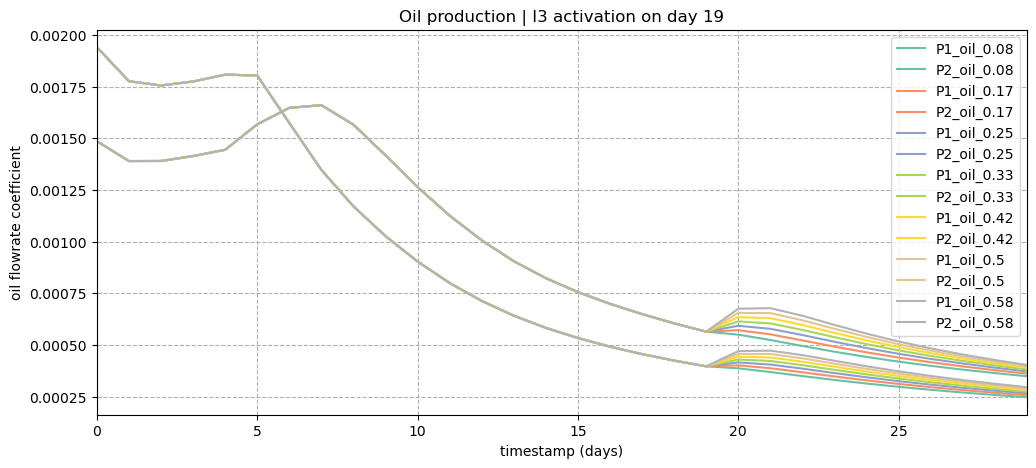

In [6]:
# create a new figure with a single set of axes
fig, ax = plt.subplots(figsize=(12, 5))

i = 0
# iterate over all combinations of coef, start_lag, and segment
for coef, start_lag, segment in itertools.product(
    coefs,
    df["start_lag"].unique()[i: i + 1],
    df["cat"].unique()[:2],
):
  # start_lag = 15
  data = df[
      (df["cat"] == segment) & (df["coef"] == coef) & (
          df["start_lag"] == start_lag)
  ]
  # select the color for the plot based on the category
  color = color_dict[coef]

  # plot the data for this combination of coef, start_lag, and segment
  ax.plot(
      data["date"],
      np.abs(data["oil"]),
      label=f"{segment}_oil_{coef}",
      color=color,
  )

# set the x-axis limits, legend location, title, and grid
ax.set_xlim(df["date"].min(), df["date"].max())
ax.set(
    title=f"Oil production | I3 activation on day {start_lag}",
    xlabel="timestamp (days)",
    ylabel="oil flowrate coefficient",
)
ax.legend(loc="best")
ax.grid(ls="--")

When the `I3` well was activated during the 19th timestep, the oil production rates (`oil`) of `P1` & `P2` began to increase. This can be attributed to the injection of water by the `I3` well into the reservoir, which supports the reservoir pressure. As a result, the reservoir pressure increases and enhances the force that drives the fluid out of the reservoir.


Text(0, 0.5, 'bhp')

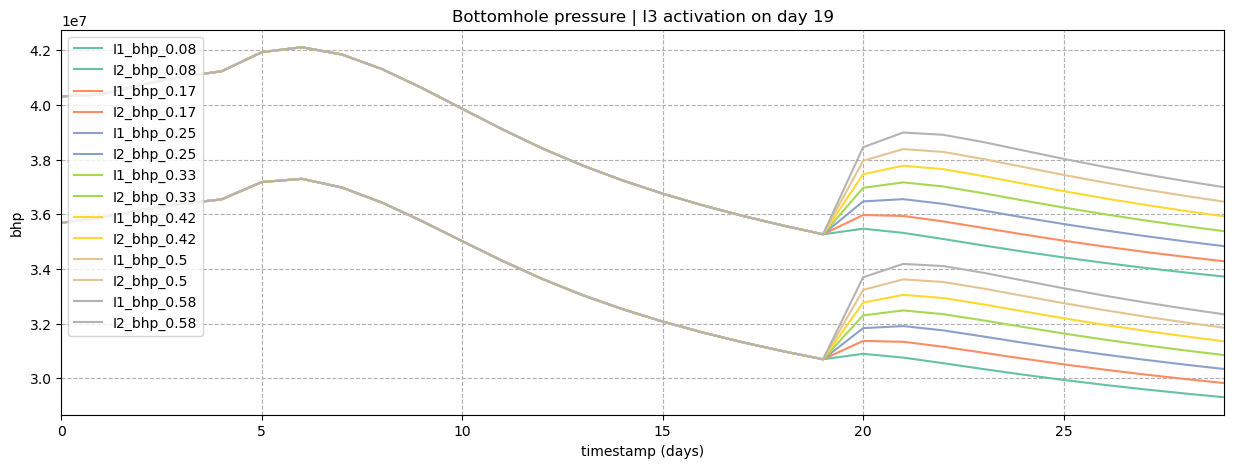

In [7]:
plt.figure(figsize=(15, 5))

for coef in coefs:
  for start_lag in df["start_lag"].unique()[:1]:
    for segment in df["cat"].unique()[2:4]:
      data = df[
          (df["cat"] == segment)
          & (df["coef"] == coef)
          & (df["start_lag"] == start_lag)
      ]
      # select the color for the plot based on the category
      color = color_dict[coef]

      plt.plot(
          data["date"],
          data["bhp"],
          label=f"{segment}_bhp_{coef}",
          color=color,
      )

plt.xlim(df["date"].min(), df["date"].max())
plt.legend(loc="upper left")
plt.title(f"Bottomhole pressure | I3 activation on day {start_lag}")
plt.grid(ls="--")
plt.xlabel("timestamp (days)")
plt.ylabel("bhp")

Furthermore, the bottomhole pressure (`bhp`) of the wells `I1` & `I2` began to increase after `I3` activation during the 19th timestep. This can be attributed to the water injection by the `I3` well into the reservoir, which supports the reservoir pressure and helps maintain the `bhp`.


---

## Applicant's code


## Setup


### Libraries


In [8]:
import os
import random
import time
import warnings
from functools import reduce

import seaborn as sns
from catboost import CatBoostRegressor
from IPython.display import clear_output, display
from scipy import stats as st
from sklearn.inspection import permutation_importance

### Notebook settings


Uncomment this line to use dark theme 🌚


In [9]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline
warnings.filterwarnings("ignore")

### Random settings


In [10]:
SEED = 2023

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

### Reusable code


\*Here I store all user-defined functions and classes to keep the main code more clean and readable.


In [11]:
def general_info(data):
  """Takes in a pandas dataframe and returns a table
  with the main statistics over the data."""

  df = pd.DataFrame()
  df["missing"] = data.isna().sum().sort_values(ascending=False)
  df["%_missing"] = (data.isna().sum() / data.isna().count()).sort_values(
      ascending=False
  )
  df["%_missing"] = pd.Series(
      ["{:.3%}".format(x) for x in df["%_missing"]], index=df.index
  )
  df["value_sample"] = data.sample().T
  df["dtype"] = data.dtypes
  describe = data.describe(include="all").round(3).T
  df = df.merge(describe, left_on=df.index, right_on=describe.index)
  df["count"] = df["count"].astype(int)
  df.rename({"key_0": "column_name", "top": "mode"}, inplace=True, axis=1)
  df["unique"] = pd.Series(
      [data[column].nunique() for column in df["column_name"]], index=df.index
  )
  df.fillna("", inplace=True)
  return df

<a id="feature-generator">


In [12]:
class FeatureGenerator:
  def __init__(self, lags_range, window_sizes, dropna=True):
    self.dropna = dropna
    self.lags_range = lags_range
    self.window_sizes = window_sizes

  def get_features(self, data, drop_start_lag=True):
    """Takes in a pandas dataframe and returns expanded dataframe
    with added lag and rolling window features. The number of lags 
    and window sizes are specified during the initialization."""

    if "start_lag" in data.columns:
      data = data.drop("start_lag", axis=1)

    features = data.columns[2:]
    data_lagged = []
    for lag, col in itertools.product(self.lags_range, features):
      data_lagged.append(data[col].shift(lag))

    col_names = [
        f"{col}_lag-{str(i)}" for i in self.lags_range for col in features]

    data_lagged = pd.concat(data_lagged, axis=1)
    data_lagged.columns = col_names

    data_rolled = []
    data_rolled_cols = []
    for window, col in itertools.product(self.window_sizes, features):
      data_rolled.append(
          data[col].shift(window - 1).rolling(window,
                                              min_periods=2).median()
      )           # shift the data to avoid target leakage
      data_rolled.append(
          data[col].shift(window - 1).rolling(window,
                                              min_periods=2).std()
      )           # shift the data to avoid target leakage

      data_rolled_cols.append("{}_roll_mean-{}".format(col, window))
      data_rolled_cols.append("{}_roll_std-{}".format(col, window))

    data_rolled = pd.concat(data_rolled, axis=1)
    data_rolled.columns = data_rolled_cols

    data = pd.concat(
        [data.drop(features, axis=1), data_lagged, data_rolled], axis=1
    )

    if self.dropna:
      data = data.dropna()

    return data

  def build_dataframe(self, input_df, combs):
    df = pd.DataFrame()
    for comb in combs:
      lag, coef = comb
      data = input_df[features].query(
          "start_lag == @lag and coef == @coef")
      data = self.get_features(data)
      df = pd.concat([df, data], axis=0)
    return df

In [13]:
def plot_one_step(y_true, y_pred, baseline):
  fig, axs = plt.subplots(1, 2, figsize=(14, 4))
  fig.suptitle(f"One-step prediction • {X_true.shape[1]} features")

  for i, col in enumerate(target_cols[:2]):
    ax = axs[i]
    ax.plot(x, abs(y_true[col]), label="true")
    ax.plot(x, abs(y_pred[col]), label="predicted")
    ax.plot(x, abs(baseline[col]), label="baseline", color="gray", ls="--")
    ax.axvline(int(lag), color="red", ls=":",
               alpha=0.5, label="I3 activation")
    ax.set(title=f"{col[:-6]}", xlabel="timestamp", ylabel="flowrate")
    ax.legend()
  plt.show()

In [14]:
def plot_multi(data, preds, test, baseline, lag):
  test = test.iloc[-10:]
  fig, axs = plt.subplots(1, 2, figsize=(14, 4))
  fig.suptitle(f"3-step horizon prediction • {X_train.shape[1]} features")

  for i, col in enumerate(["oil_P1", "oil_P2"]):
    ax = axs[i]
    ax.plot(test["date"], abs(test[col]), label="target")
    ax.scatter(
        preds["date"],
        list(abs(baseline[col])) * 3,
        label="baseline",
        marker="o",
        color="gray",
    )
    ax.scatter(
        preds["date"],
        abs(preds[col]),
        label="predicted",
        marker="x",
        color="orange",
    )
    ax.axvline(int(lag), color="red", ls=":",
               alpha=0.5, label="I3 activation")
    ax.set(title=f"{col}", xlabel="timestamp", ylabel="flowrate")
    ax.legend()
  plt.show()

---

## EDA and preprocessing


### Simulation parameters


Let's examine the various combinations of `start_lag` and `coef` values that are available.


In [15]:
combs = pd.DataFrame(df.groupby("start_lag")["coef"].unique())
combs

,coef
start_lag,
0,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"
2,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"
3,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"
4,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"
6,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"
7,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"
8,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"
9,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"
12,"[0.42, 0.17, 0.33, 0.58, 0.5, 0.25, 0.08]"


Despite the task description calling for 18 simulations, only 17 were available after data cleaning due to a loading error. There are also gaps in the series.


### Inactive wells


Let's look how many records have status of inactive wells.


In [16]:
df.query("status == 0")["cat"].unique()

array(['I3'], dtype=object)

Inactive status occurs only among `I3` wells.

Look at the proportion of inactive injector with different start lag and timestamp values:


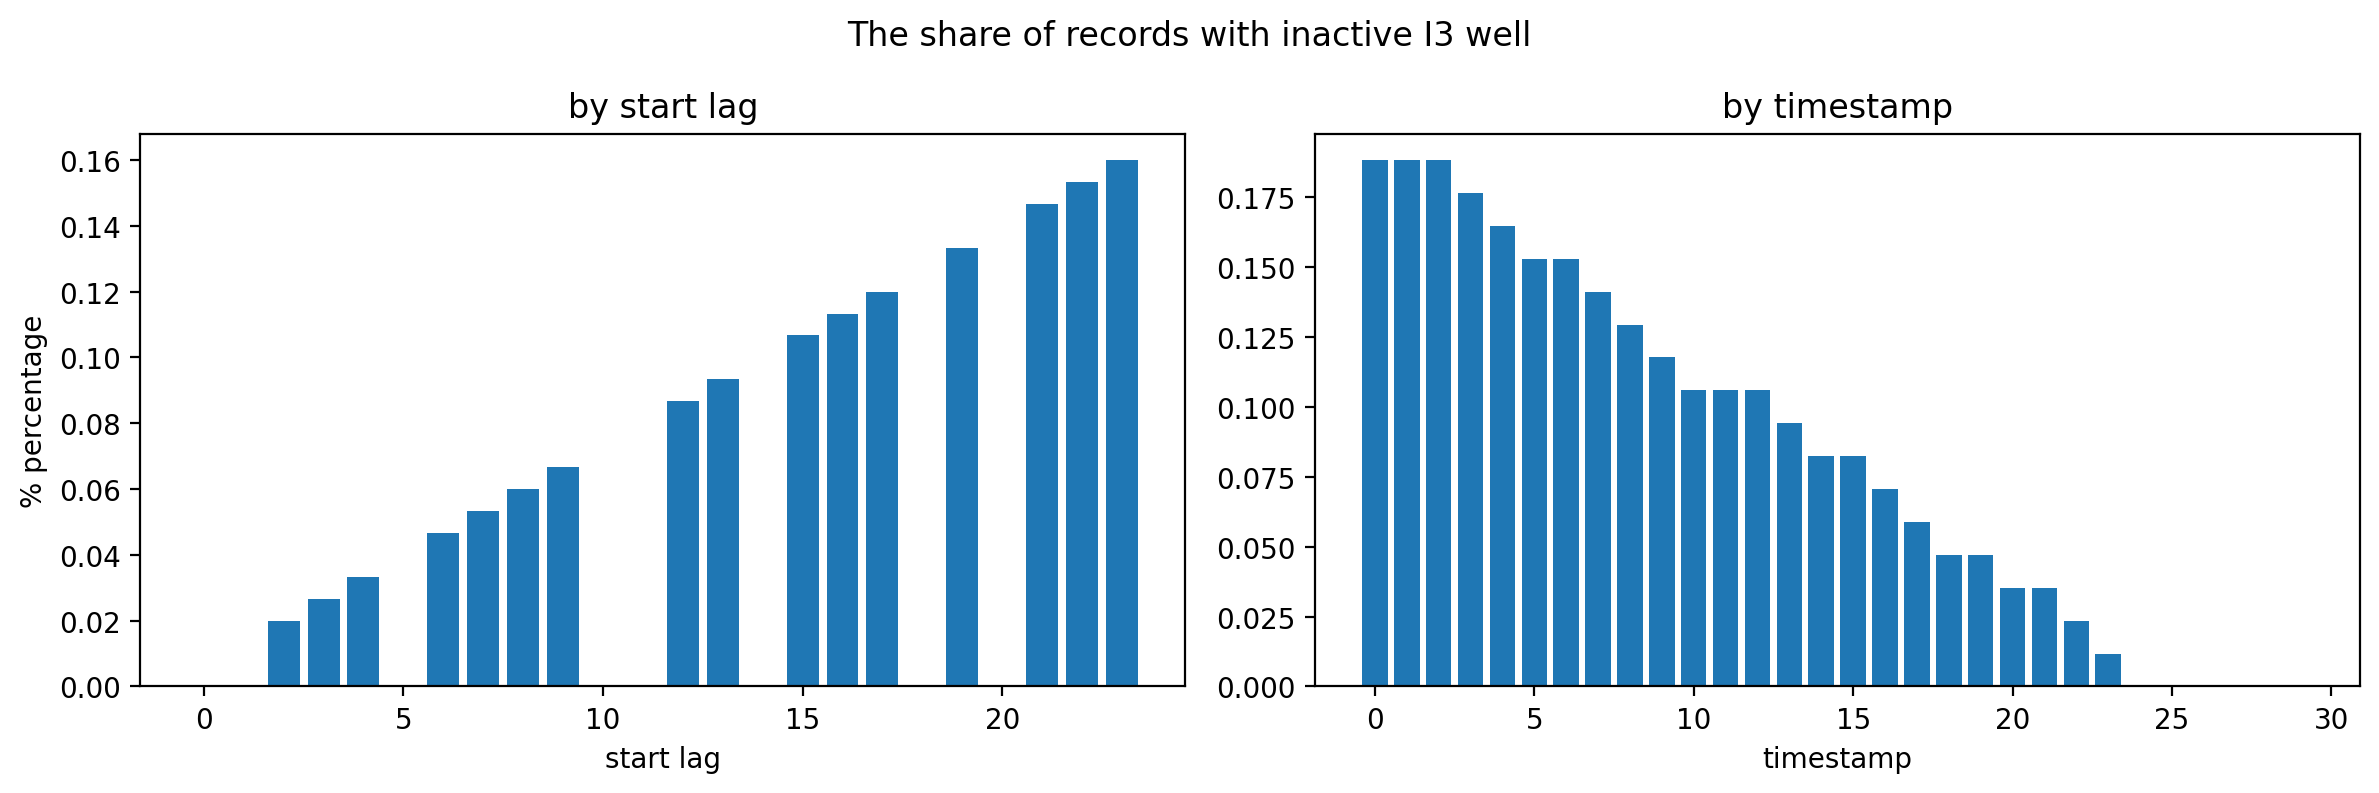

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("The share of records with inactive I3 well")

ax = axs[0]
data = df.groupby(["start_lag"], as_index=False)["status"].mean()
ax.bar(data["start_lag"], 1 - data["status"])
ax.set(title="by start lag", xlabel="start lag", ylabel="% percentage")

ax = axs[1]
data = df.groupby(["date"], as_index=False)["status"].mean()
ax.bar(data["date"], 1 - data["status"])
ax.set(title="by timestamp", xlabel="timestamp")

fig.tight_layout()

See the ratio if inactive wells among different activation coefficients:


In [18]:
data = df.groupby(["coef"], as_index=False)["status"].mean()
data

,coef,status
0,0.08,0.916471
1,0.17,0.916471
2,0.25,0.916471
3,0.33,0.916471
4,0.42,0.916471
5,0.50,0.916471
6,0.58,0.916471


Clearly, the inactive status of well `I3` (`status=0`) is set such because of its delayed activation during different simulations.

A piece from the task statement:

> `status` - This feature indicates whether the well is active or not. Even if there is a flow of liquid, if the value of status is 0, the well is not considered to be participating in the simulation.

Let's check the flowrates for the records with such status:


In [19]:
general_info(df.query("cat == 'I3' and status == 0"))

,column_name,missing,%_missing,value_sample,dtype,count,unique,mode,freq,mean,std,min,25%,50%,75%,max
0,oil,1491,100.000%,,float64,0,0,,,,,,,,,
1,water,1491,100.000%,,float64,0,0,,,,,,,,,
2,liquid,1491,100.000%,,float64,0,0,,,,,,,,,
3,bhp,1491,100.000%,,float64,0,0,,,,,,,,,
4,cat,0,0.000%,I3,object,1491,1,I3,1491,,,,,,,
5,group,0,0.000%,I,object,1491,1,I,1491,,,,,,,
6,date,0,0.000%,1,int64,1491,24,,,7.873,5.918,0.0,3.0,7.0,12.0,23.0
7,status,0,0.000%,0,int64,1491,1,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,start_lag,0,0.000%,22,int64,1491,16,,,15.746,5.93,2.0,12.0,17.0,21.0,23.0
9,coef,0,0.000%,0.33,float64,1491,7,,,0.333,0.167,0.08,0.17,0.33,0.5,0.58


Everything looks good: there is no flowrate and buttomhole pressure values for inactive wells.


In [20]:
# fill in missing values with zeros
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17850 entries, 0 to 17849
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cat        17850 non-null  object 
 1   group      17850 non-null  object 
 2   date       17850 non-null  int64  
 3   oil        17850 non-null  float64
 4   water      17850 non-null  float64
 5   liquid     17850 non-null  float64
 6   bhp        17850 non-null  float64
 7   status     17850 non-null  int64  
 8   start_lag  17850 non-null  int64  
 9   coef       17850 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 1.4+ MB


### `bhp` for production wells


Look at the buttomhole pressure of the production wells, does it change?


In [21]:
df.query("group == 'P'")["bhp"].value_counts()

20000000.0    7140
Name: bhp, dtype: int64

`bhp` value for production wells is a constant: it doesn't change during simulataions, hence it doesn't have predictive power over the target.


### Master dataset


First, upscale the oil flowrate and downscale the bottomhole pressure values so they will be more readable for both humans and computers. It is convenient to do it here, while they're all in one line.


In [22]:
df.iloc[:, 3:6] *= 1e4
df.iloc[:, 6] /= 1e6

In [23]:
df.head()

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef
0,P1,P,0,-14.856979,0.000000,-14.856979,20.000000,1,19,0.42
1,P2,P,0,-19.405064,0.000000,-19.405064,20.000000,1,19,0.42
2,I1,I,0,0.000000,25.496799,25.496799,40.311418,1,19,0.42
3,I2,I,0,0.000000,12.748399,12.748399,35.688705,1,19,0.42
4,I3,I,0,0.000000,0.000000,0.000000,0.000000,0,19,0.42


Next, rearrange the data so that each record in the dataset will store all information corresponding to its distinct timestamp. Keep in mind that injector wells don't really have any oil flowrate and bottomhole pressure in production wells is constant, hence irrelevant as a feature.

_p.s. I'm sorry for the following wall of code. It feels like there should be a more concise way to do this, but it didn't come to my mind._

Unpack, drop redundant columns, and rename existing columns for the processing wells:


In [24]:
cols2drop = ["cat", "bhp", "group", "status"]

cat = "P1"
data_p1 = df.query("cat == @cat").drop(cols2drop, axis=1)
data_p1.rename(
    {"oil": f"oil_{cat}", "water": f"water_{cat}", "liquid": f"liquid_{cat}"},
    axis=1,
    inplace=True,
)

cat = "P2"
data_p2 = df.query("cat == @cat").drop(cols2drop, axis=1)
data_p2.rename(
    {"oil": f"oil_{cat}", "water": f"water_{cat}", "liquid": f"liquid_{cat}"},
    axis=1,
    inplace=True,
)

Do the same for the injector wells:


In [25]:
cols2drop = ["cat", "oil", "group", "status"]

cat = "I1"
data_i1 = df.query("cat == @cat").drop(cols2drop, axis=1)
data_i1.rename(
    {"water": f"water_{cat}", "liquid": f"liquid_{cat}", "bhp": f"bhp_{cat}"},
    axis=1,
    inplace=True,
)

cat = "I2"
data_i2 = df.query("cat == @cat").drop(cols2drop, axis=1)
data_i2.rename(
    {"water": f"water_{cat}", "liquid": f"liquid_{cat}", "bhp": f"bhp_{cat}"},
    axis=1,
    inplace=True,
)

cat = "I3"
data_i3 = df.query("cat == @cat").drop(cols2drop, axis=1)
data_i3.rename(
    {"water": f"water_{cat}", "liquid": f"liquid_{cat}", "bhp": f"bhp_{cat}"},
    axis=1,
    inplace=True,
)

Set the data back together:


In [26]:
# store the resulting dataframes in a list
data2merge = [data_p1, data_p2, data_i1, data_i2, data_i3]
cols4merge = ["date", "start_lag", "coef"]

# merge all dataframes into one table
master_df = reduce(
    lambda df_left, df_right: pd.merge(
        df_left, df_right, on=cols4merge, how="outer"),
    data2merge,
)

# set the data in order
master_df = master_df.sort_values(by=["start_lag", "coef", "date"]).reset_index(
    drop=True
)

# see whether all records got distributed evenly
(
    master_df.groupby(["start_lag", "coef"], as_index=False)["date"]
    .count()["date"]
    .value_counts()
)

30    119
Name: date, dtype: int64

In [27]:
# see the number of unique lag + coef combinations
df["start_lag"].nunique() * df["coef"].nunique()

119

Good. Now we have 30-days simulation data for each of 119 unique combinations of `start_lag` and `coef` values.


### Relashionship between features


Plot the correlation matrix to see which features are most-correlated:


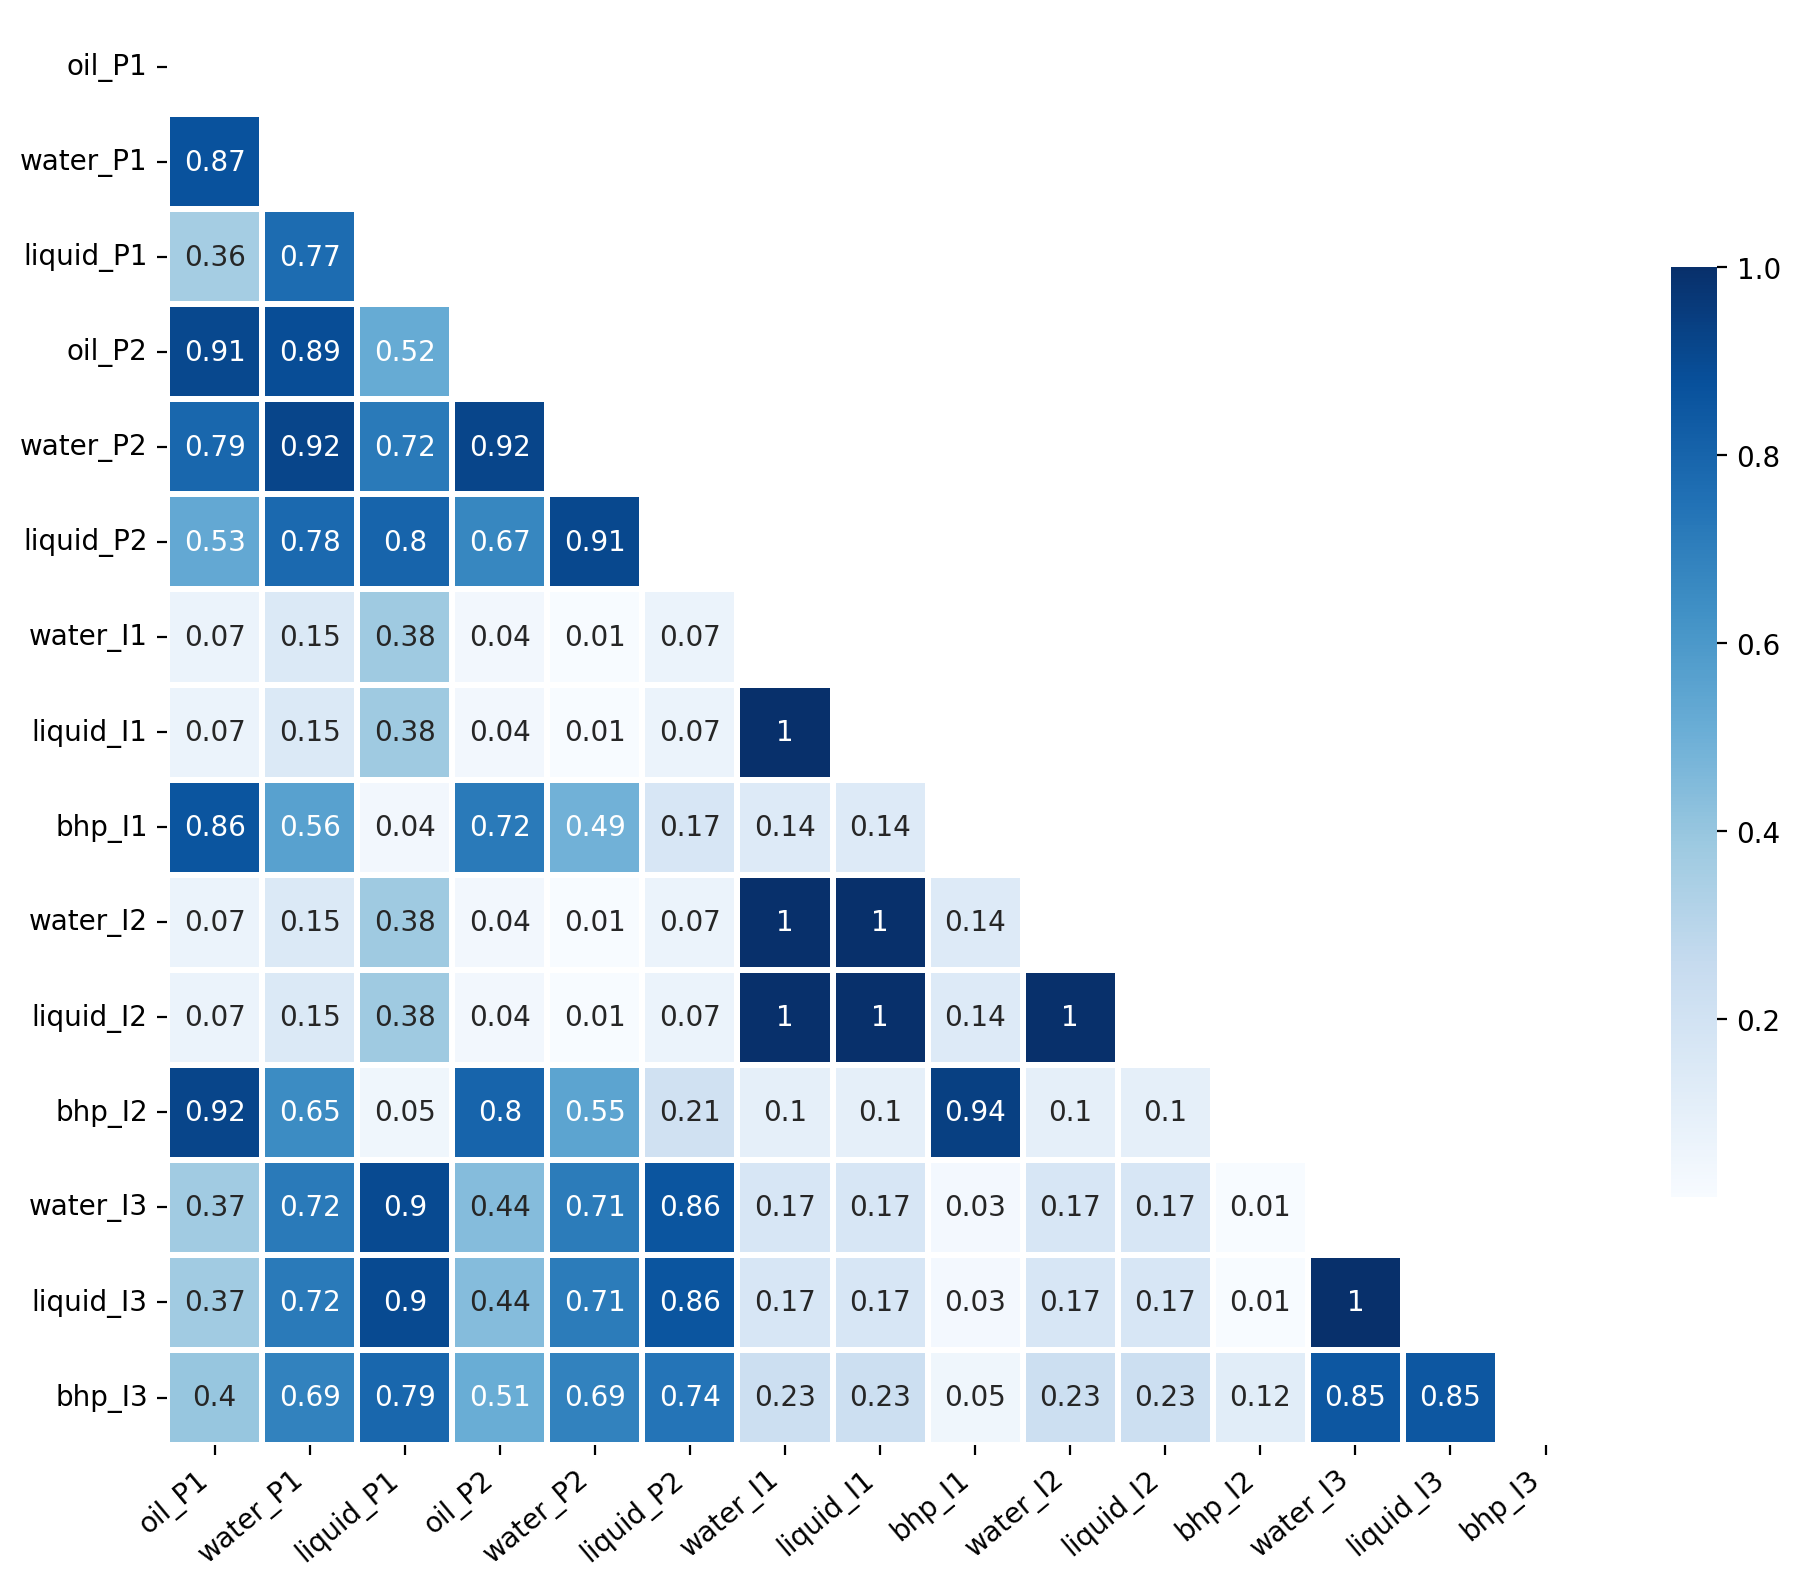

In [28]:
# create a list of column names with irrelevant features excluded
cols2drop = ["start_lag", "coef", "date"]
cols2keep = [col for col in master_df.columns if col not in cols2drop]

# calculate the correlation matrix
corr_matrix = master_df[cols2keep].corr().abs().round(2)
# create a mask to filter out duplicate values
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 10))

# correlation matrix
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    square=True,
    cmap="Blues",
    cbar_kws={"fraction": 0.03},
    linewidth=2,
    mask=mask,
)
heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=40, horizontalalignment="right"
)
plt.show()

The task suggests to choose the target:

> You may choose to forecast oil or liquid flowrates.

**I decided to choose the oil flow rate as the target**, because it seems to be the metric that the company is really after, with liquid flow rate being a secondary metric.

From the heatmap graph, we can see that the oil flowrates of wells P1 and P2 are mostly correlated between each other and the buttomhole pressure of the injection wells. These features will be used for modeling.


### train-valid-test splitting


Create a set of all possible `start_lag` + `coef` combinations.


In [29]:
# get arrays of uniq lag and coef values
lags = sorted(df["start_lag"].unique())
coefs = sorted(df["coef"].unique())

# Create a set of all possible combinations of the two variables
combs = list(itertools.product(lags, coefs))
combs = np.array(combs)

# print several sets of combinations
print(combs[:7])

[[0.   0.08]
 [0.   0.17]
 [0.   0.25]
 [0.   0.33]
 [0.   0.42]
 [0.   0.5 ]
 [0.   0.58]]


Glance at the first combination:


In [30]:
features = [
    "start_lag",
    "coef",
    "date",
    "oil_P1",
    "oil_P2",
    "bhp_I1",
    "bhp_I2",
    "bhp_I3",
]

lag, coef = combs[0]
master_df = master_df[features]
data = master_df.query("start_lag == @lag and coef == @coef")
data.head()

,start_lag,coef,date,oil_P1,oil_P2,bhp_I1,bhp_I2,bhp_I3
0,0,0.08,0,-16.273422,-19.129746,40.460525,36.927346,34.007209
1,0,0.08,1,-15.184469,-17.708576,40.673106,37.083406,34.915512
2,0,0.08,2,-15.224787,-17.643931,41.128439,37.427105,35.504849
3,0,0.08,3,-15.554158,-17.951218,41.473868,37.703283,35.899004
4,0,0.08,4,-15.961655,-18.383806,41.737812,37.925359,36.190256


In [31]:
# generate indices for training, validation, and test parts
ids = np.random.choice(119, 119, replace=False)
combs_train = combs[ids[:80]]
combs_valid = combs[ids[80:100]]
combs_test = combs[ids[100:]]

We have a fairly small dataset to train on. To make it bigger and help the model avoid overfitting, apply the bootstrapping trick:


In [32]:
combs_train = [combs_train[i] for i in np.random.choice(80, 300, replace=True)]

### Features engineering


The code for generating features is stored in the [FeatureGenerator](#feature-generator) class in the "reusable code" section. It takes a range of lag values and window sizes for calculating rolling mean and standard deviation statistics during initialization. Then, with the `build_dataframe` method, we can add features to the data with the previously specified parameters.


Initialize the generator with the desired parameters and enrich the datasets with new features:


In [33]:
lags = np.arange(11)
window_sizes = np.arange(2, 11)

generator = FeatureGenerator(lags, window_sizes)

In [34]:
train_data = generator.build_dataframe(master_df, combs_train)
train_data.shape

(6000, 147)

In [35]:
valid_data = generator.build_dataframe(master_df, combs_valid)
valid_data.shape

(400, 147)

---

## Modeling


For this task, the **CatBoost** framework was selected. It yields good performance without the need for hyperparameter tuning, which is desired to avoid in this project. It also has built-in functionality for features selection, which will come in handy later.

As we are free to choose the baseline, the most popular time series sanity-check will be used: simply use **the value from the previous day as the baseline**.

To make predictions over a multiple-step horizon, we will use the **recursive method**, in which the model chooses its last predicted value as an input and makes a prediction again. In this case, we need to **predict all the selected features**, which turns the problem into a multiple-output regression. This approach allows the model to capture the dependencies between the output variables and provides a more comprehensive forecast for the target horizon.


### Fit the model


In [36]:
target_cols = [
    "oil_P1_lag-0",
    "oil_P2_lag-0",
    "bhp_I1_lag-0",
    "bhp_I2_lag-0",
    "bhp_I3_lag-0",
]
X_train = train_data.drop(target_cols, axis=1)
y_train = train_data[target_cols]

X_valid = valid_data.drop(target_cols, axis=1)
y_valid = valid_data[target_cols]

metric = "MultiRMSE"
model = CatBoostRegressor(
    random_state=SEED, loss_function=metric, eval_metric=metric, verbose=False
)

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

In [37]:
model.best_score_

{'learn': {'MultiRMSE': 0.22470848626020487},
 'validation': {'MultiRMSE': 0.4636574339879126}}

### One-step prediction


See how model performs one a one-step horizon:


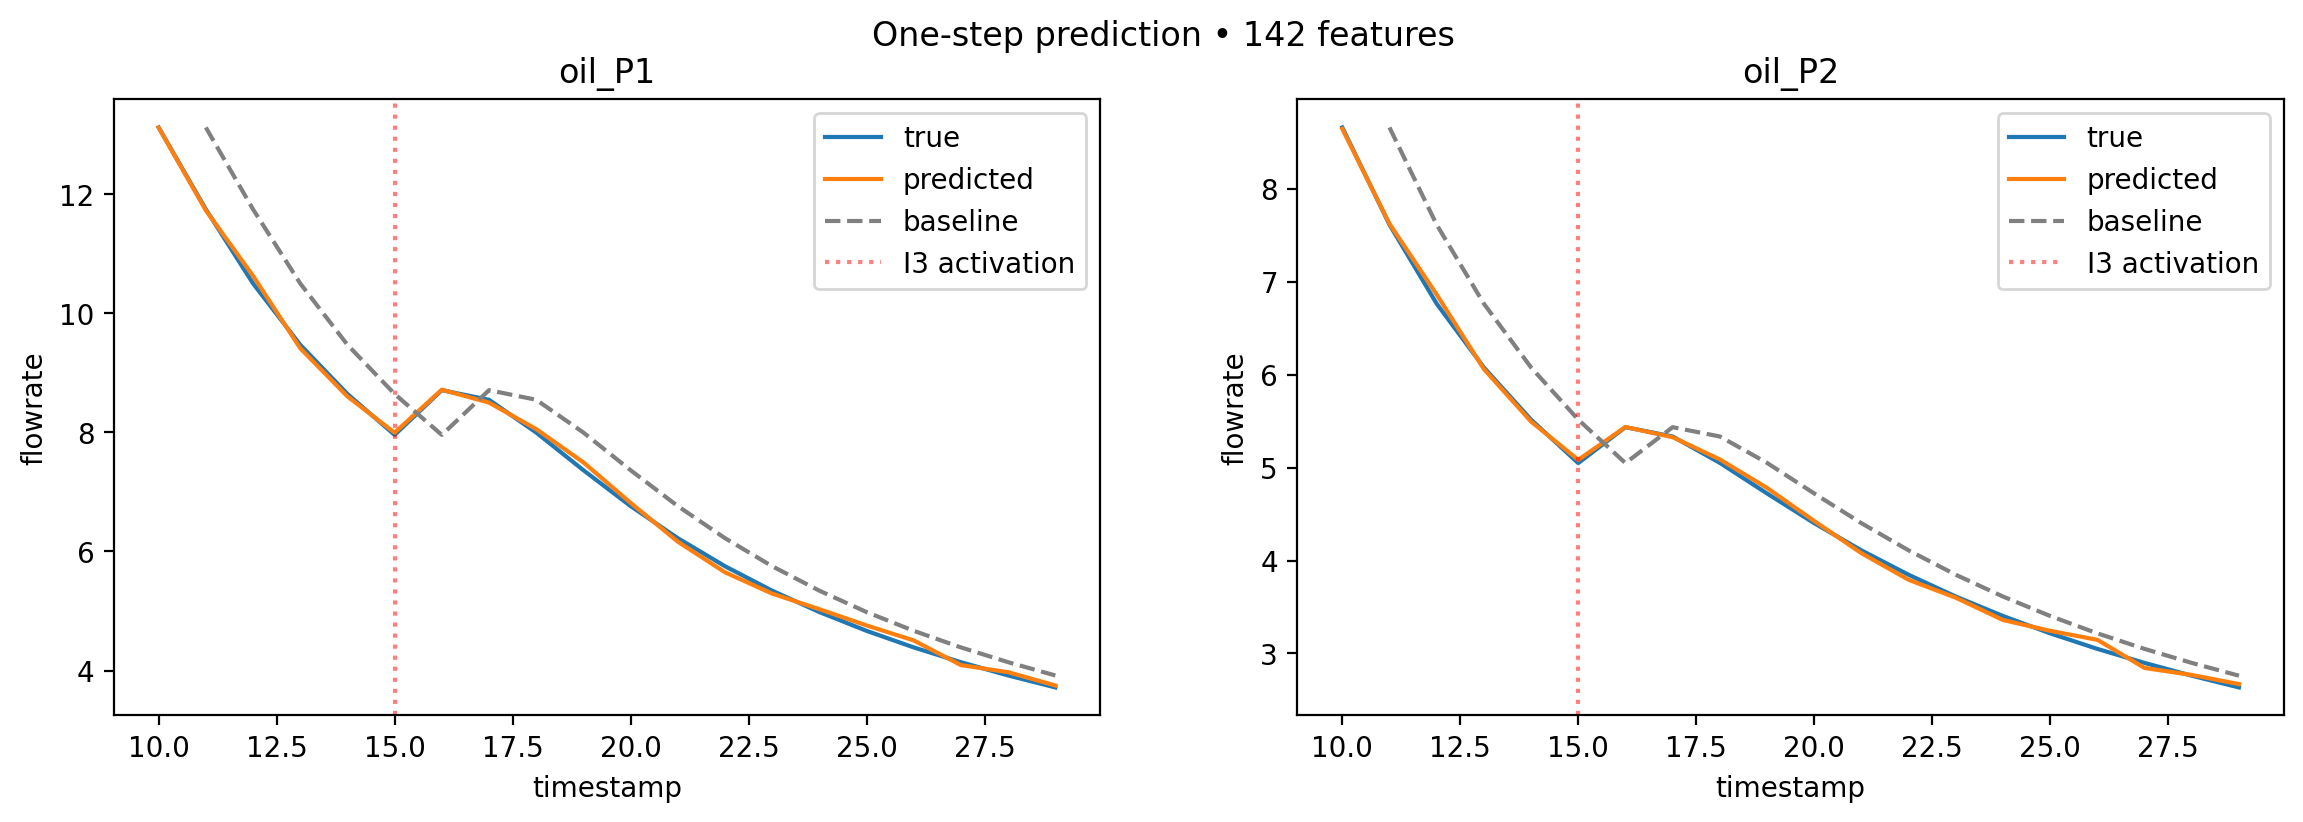

In [38]:
lag, coef = combs_valid[0]
data = master_df.query("start_lag == @lag and coef == @coef")
test_data = generator.get_features(data)

X_true = test_data.drop(target_cols, axis=1)
y_true = test_data[target_cols]

y_pred = model.predict(X_true)
y_pred = pd.DataFrame(y_pred, columns=target_cols)

baseline = y_true.shift()
x = X_true["date"]

plot_one_step(y_true, y_pred, baseline)

The model fits the line quite well. It is clearly more accurate then the baseline. But the task is prediction over a 3-step horizon.


### Multi-step prediction


In the context of the task, we are not that much interested in predicting baseline flowrate. It would be quite easy after all. What we are really interested in is what happens when the new well gets activated. Therefore, the model will be making predictions starting from the `I3` activation day.


The following code expands the input dataframe with the predicted values and uses this updated dataframe to make the next predictions, regenerating rolling statistics and lag values along the way. We can predict over as many steps as we want, but we'll stick to 3-steps horizon specified in the task.


In [39]:
def predict_multi(lag, coef, horizon_steps=3):
  n_start = int(lag) + 1
  data = master_df.query("start_lag == @lag and coef == @coef")
  data.drop("start_lag", axis=1, inplace=True)
  test = data.copy()

  i = 0
  while i < horizon_steps:
    input_data = generator.get_features(data.iloc[:n_start + 1 + i])
    input_row = input_data.iloc[-1].drop(target_cols)
    prediction = model.predict(input_row)
    data.iloc[n_start + i, 2:] = prediction
    i += 1

  baseline = data[data["date"] == lag]
  preds = data.iloc[n_start: n_start + horizon_steps]
  test = test.iloc[: n_start + horizon_steps]

  return data, preds, test, baseline, lag

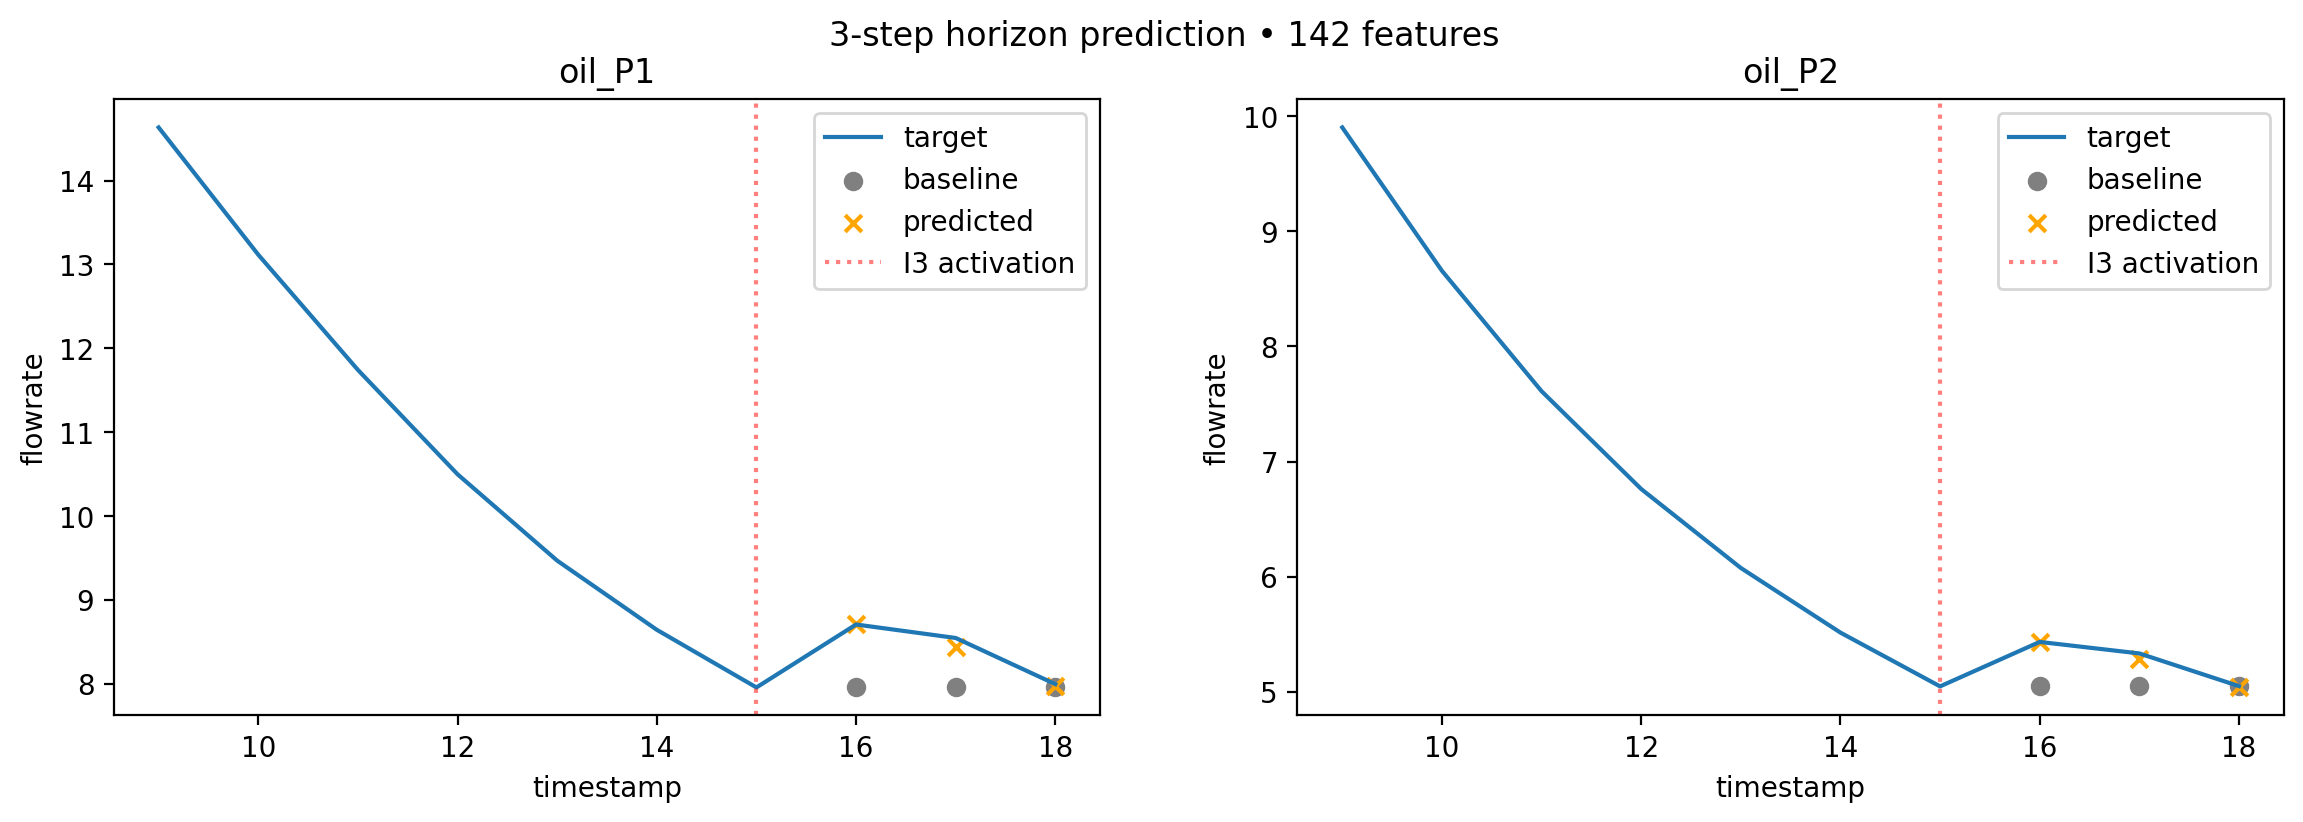

In [40]:
plot_multi(*predict_multi(lag, coef))

### Features importance analysis


Having 10 lagged values and the same amount of rolling windows for each feature is a lot of information to keep. And the task focus is really on features selection rather than on the model's score.

> Your task is to come up with the methodology to select features and evaluate time lags which should be used to build a robust predictive model for forecasting the flow rates of **production wells**...

Let's find out which features are the most important using the `permutation_importance` framework from the scikit-learn library.


Text(0.5, 1.0, 'Permutation features importance')

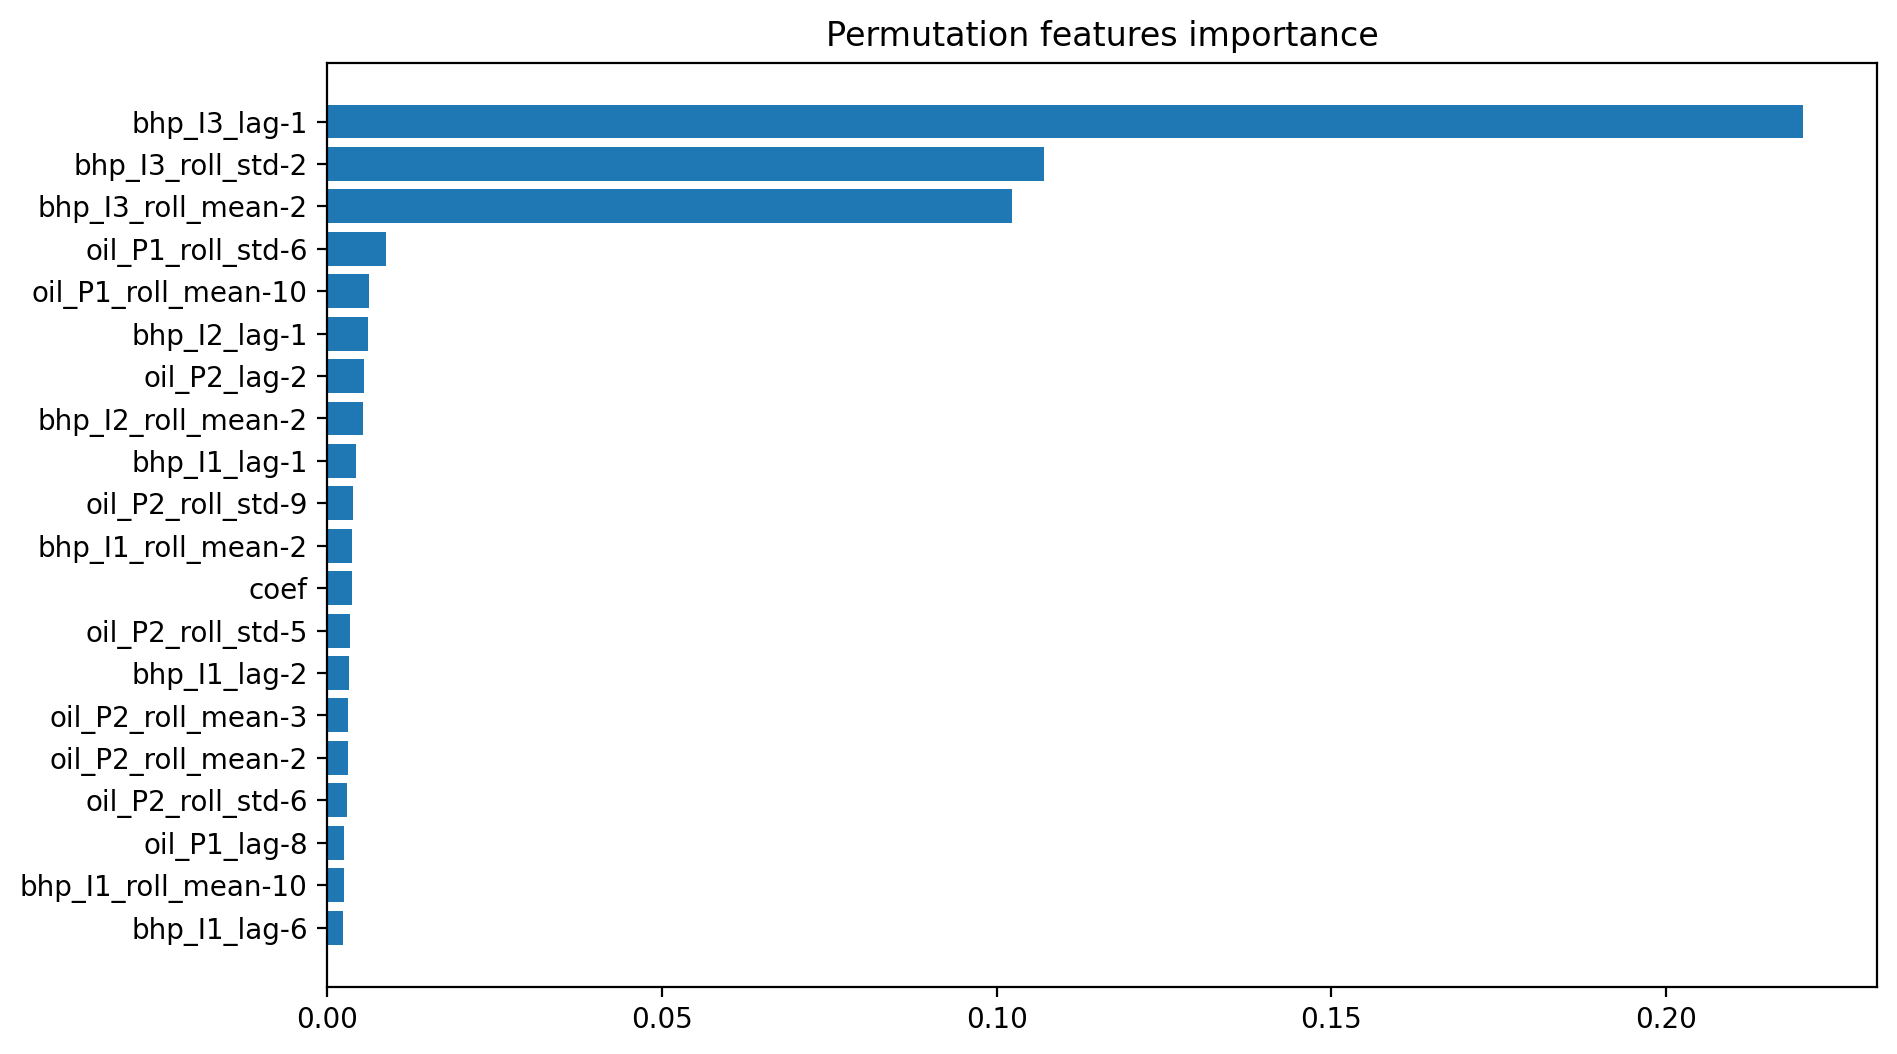

In [41]:
importance = permutation_importance(
    model, X_valid, y_valid, n_repeats=10, random_state=SEED
).importances_mean

n_top = 20
ids = np.argsort(importance)
top_features = X_train.columns[ids][-n_top:]

fig = plt.figure(figsize=(10, 6))
plt.barh(range(n_top), importance[ids][-n_top:], align="center")
plt.yticks(range(n_top), top_features)
plt.title("Permutation features importance")

By far the most important features are the bottomhole pressure of the `I3` injector from the previous day and rolling statistics for the same well with the window of 2 days.

Let's plot these values to see whether we can gain any insight from this fact:


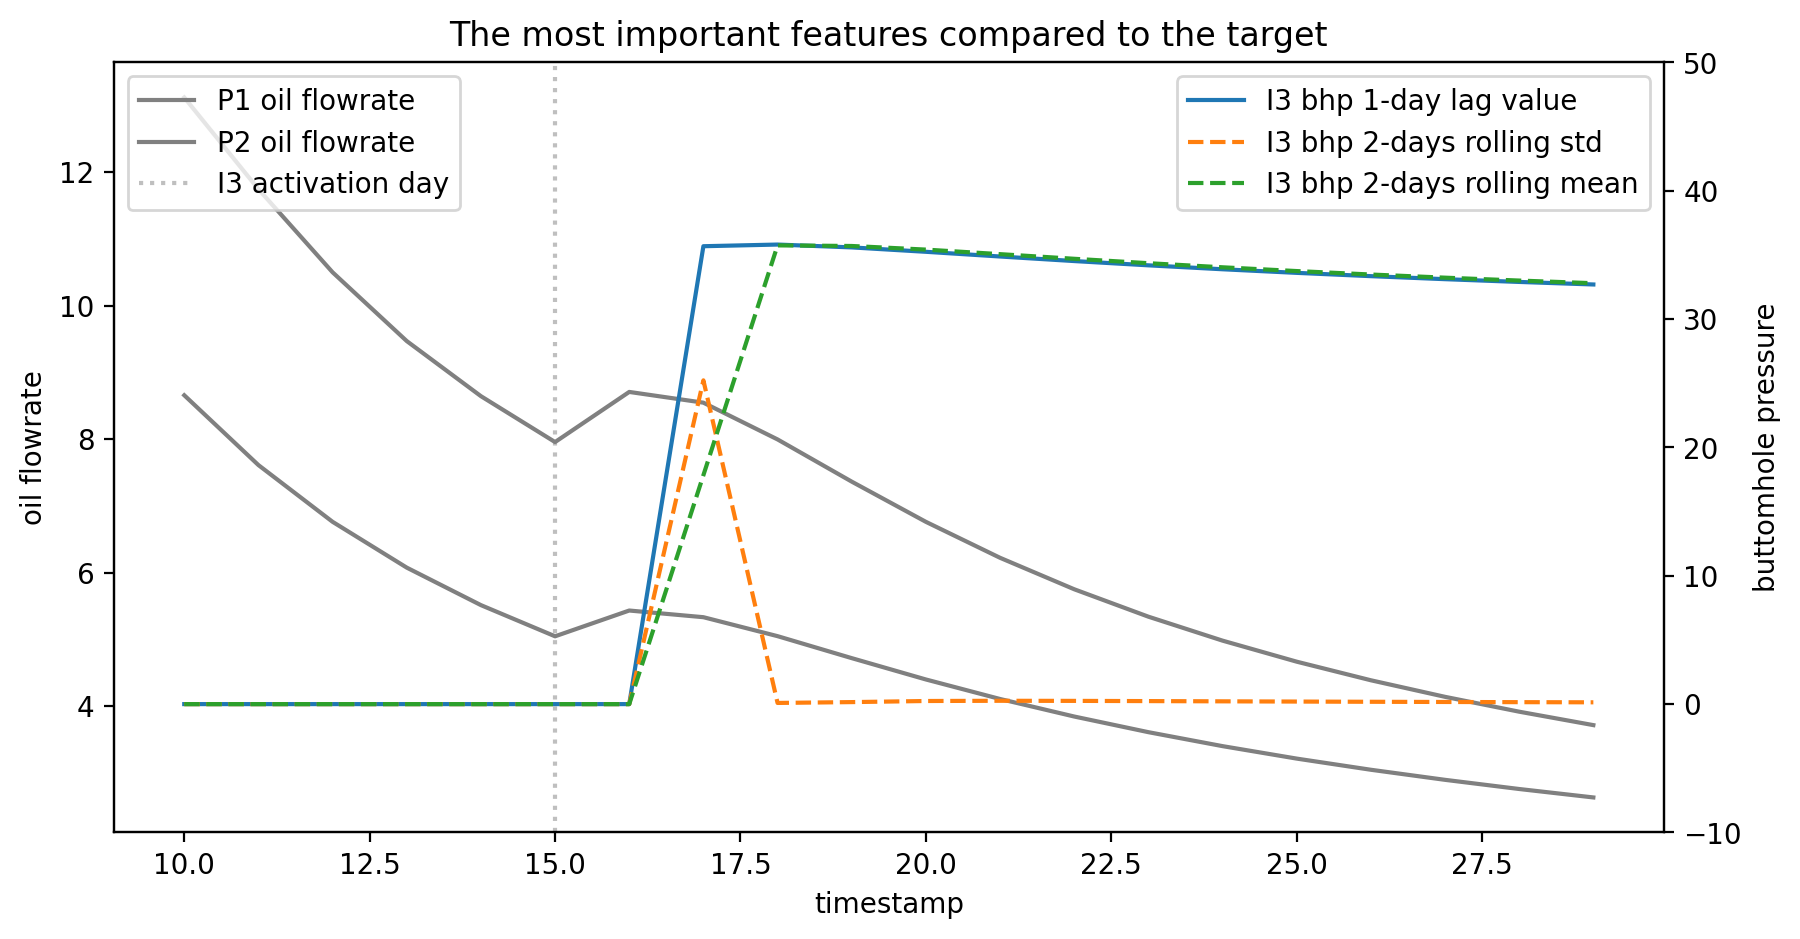

In [42]:
data = master_df.query("start_lag == @lag and coef == @coef")
data = generator.get_features(data)

fig, ax1 = plt.subplots(figsize=(10, 5))

x = data["date"]
color = "gray"
ax1.plot(x, abs(data["oil_P1_lag-0"]), c=color, label="P1 oil flowrate")
ax1.plot(x, abs(data["oil_P2_lag-0"]), c=color, label="P2 oil flowrate")
ax1.axvline(int(lag), color="gray", ls=":",
            alpha=0.5, label="I3 activation day")
ax1.set(
    title="The most important features compared to the target",
    ylabel="oil flowrate",
    xlabel="timestamp",
)
ax1.legend(loc="upper left")


ax2 = ax1.twinx()
ax2.plot(x, data["bhp_I3_lag-1"], label="I3 bhp 1-day lag value")
ax2.plot(x, data["bhp_I3_roll_std-2"], ls="--",
         label="I3 bhp 2-days rolling std")
ax2.plot(x, data["bhp_I3_roll_mean-2"], ls="--",
         label="I3 bhp 2-days rolling mean")
ax2.set(ylim=(-10, 50), ylabel="buttomhole pressure")
ax2.legend(loc="upper right")

From the plot, we can assume that the model uses the `I3` well parameters from the previous day to estimate how strongly today's flowrate will be affected.


### Features selection


We can use CatBoost built-in functionality to reduce the number of features and see which are the most important ones.


In [43]:
# see the number of features at the moment
X_train.shape

(6000, 142)

In [44]:
summary = model.select_features(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    features_for_select="2-141",
    num_features_to_select=50,
    steps=10,
    train_final_model=False,
    logging_level="Silent",
)

Let's look at the selected rolling statistics and lag features separately so it would be easier to analyze them.


In [45]:
selected_features = summary["selected_features_names"]
[x for x in selected_features if "lag" in x]

['oil_P2_lag-1',
 'bhp_I1_lag-1',
 'bhp_I2_lag-1',
 'bhp_I3_lag-1',
 'oil_P2_lag-2',
 'bhp_I3_lag-2',
 'oil_P2_lag-3',
 'oil_P2_lag-4',
 'oil_P1_lag-5',
 'oil_P2_lag-5',
 'bhp_I1_lag-5',
 'bhp_I1_lag-6',
 'oil_P1_lag-8',
 'oil_P1_lag-9',
 'oil_P2_lag-9',
 'oil_P1_lag-10']

Lags values of 1, 2, 5, and 9 occur the most often.


In [46]:
[x for x in selected_features if "roll" in x]

['oil_P1_roll_mean-2',
 'oil_P1_roll_std-2',
 'oil_P2_roll_mean-2',
 'bhp_I1_roll_mean-2',
 'bhp_I1_roll_std-2',
 'bhp_I2_roll_mean-2',
 'bhp_I2_roll_std-2',
 'bhp_I3_roll_mean-2',
 'bhp_I3_roll_std-2',
 'oil_P1_roll_mean-3',
 'oil_P1_roll_std-3',
 'oil_P2_roll_std-3',
 'bhp_I1_roll_mean-3',
 'bhp_I1_roll_mean-4',
 'oil_P1_roll_std-5',
 'oil_P2_roll_std-5',
 'oil_P1_roll_std-6',
 'oil_P2_roll_std-6',
 'bhp_I1_roll_std-6',
 'bhp_I2_roll_std-6',
 'oil_P2_roll_std-7',
 'bhp_I1_roll_mean-7',
 'bhp_I2_roll_std-7',
 'oil_P1_roll_mean-8',
 'oil_P1_roll_mean-9',
 'oil_P1_roll_std-9',
 'oil_P2_roll_std-9',
 'bhp_I1_roll_mean-9',
 'bhp_I2_roll_std-9',
 'oil_P1_roll_mean-10',
 'oil_P2_roll_mean-10',
 'oil_P2_roll_std-10',
 'bhp_I1_roll_mean-10',
 'bhp_I2_roll_mean-10']

Having many rolling statistics turns out to be more important for the model than simple lags. It looks like windows of sizes 3, 4, 5, 6, 9, and 10 stand out from the rest.


### Refit the model


Initialize the feature generator with fewer parameters:


In [47]:
lags = [0, 1, 2, 5, 9]
window_sizes = [2, 3, 5, 6, 9, 10]

generator = FeatureGenerator(lags, window_sizes)

Rebuild the training and validation data and fit the model again:


In [48]:
train_data = generator.build_dataframe(master_df, combs_train)
train_data.shape

(6000, 87)

In [49]:
valid_data = generator.build_dataframe(master_df, combs_valid)
valid_data.shape

(400, 87)

In [50]:
X_train = train_data.drop(target_cols, axis=1)
y_train = train_data[target_cols]

X_valid = valid_data.drop(target_cols, axis=1)
y_valid = valid_data[target_cols]

metric = "MultiRMSE"
model = CatBoostRegressor(
    random_state=SEED, loss_function=metric, eval_metric=metric, verbose=False
)

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

In [51]:
model.best_score_

{'learn': {'MultiRMSE': 0.22722185720140245},
 'validation': {'MultiRMSE': 0.4256086298626813}}

Model's scoring on the validation even improved, but we have too tiny validation sample to make big conclusions.  
\*previous score:

```
{'learn': {'MultiRMSE': 0.22470848626020487},
 'validation': {'MultiRMSE': 0.4636574339879126}}
```


### Plot predictions


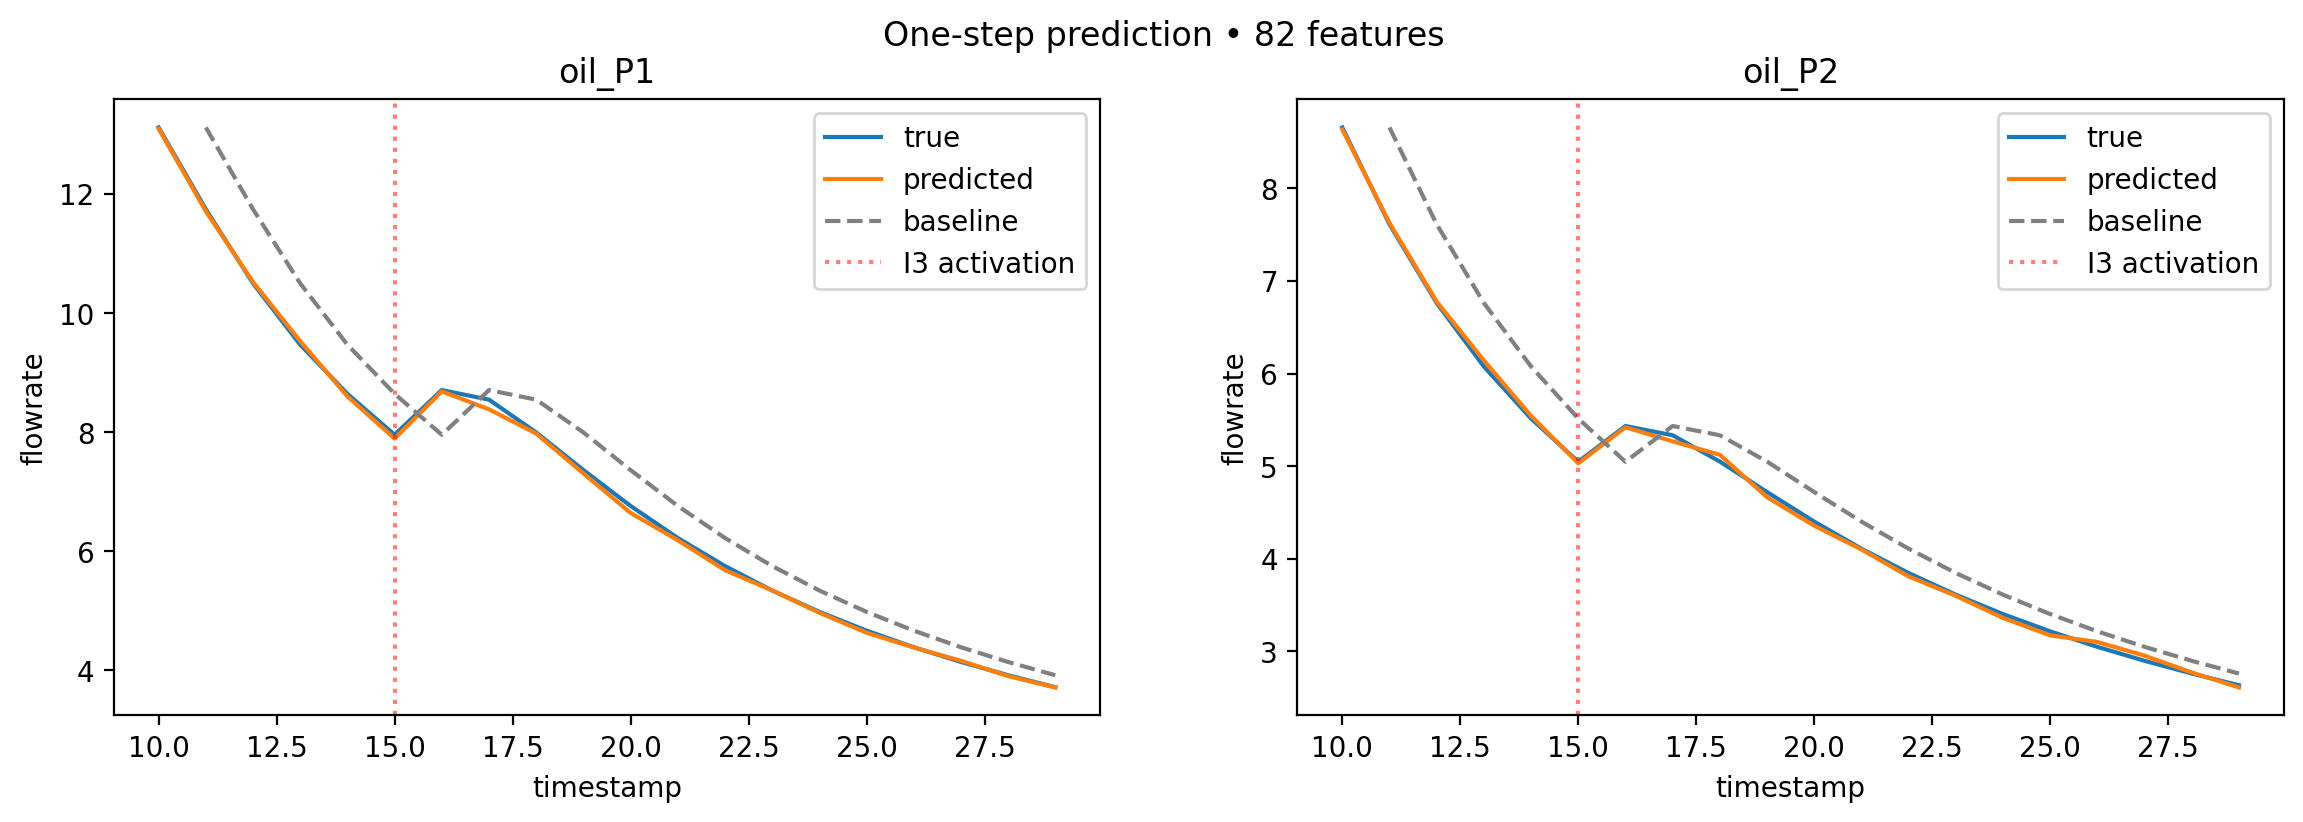

In [52]:
lag, coef = combs_valid[0]
data = master_df[features].query("start_lag == @lag and coef == @coef")
test_data = generator.get_features(data)

X_true = test_data.drop(target_cols, axis=1)
y_true = test_data[target_cols]

y_pred = model.predict(X_true)
y_pred = pd.DataFrame(y_pred, columns=target_cols)

baseline = y_true.shift()
x = X_true["date"]

plot_one_step(y_true, y_pred, baseline)

The line became more curvy, but not too much and still way better than the baseline.


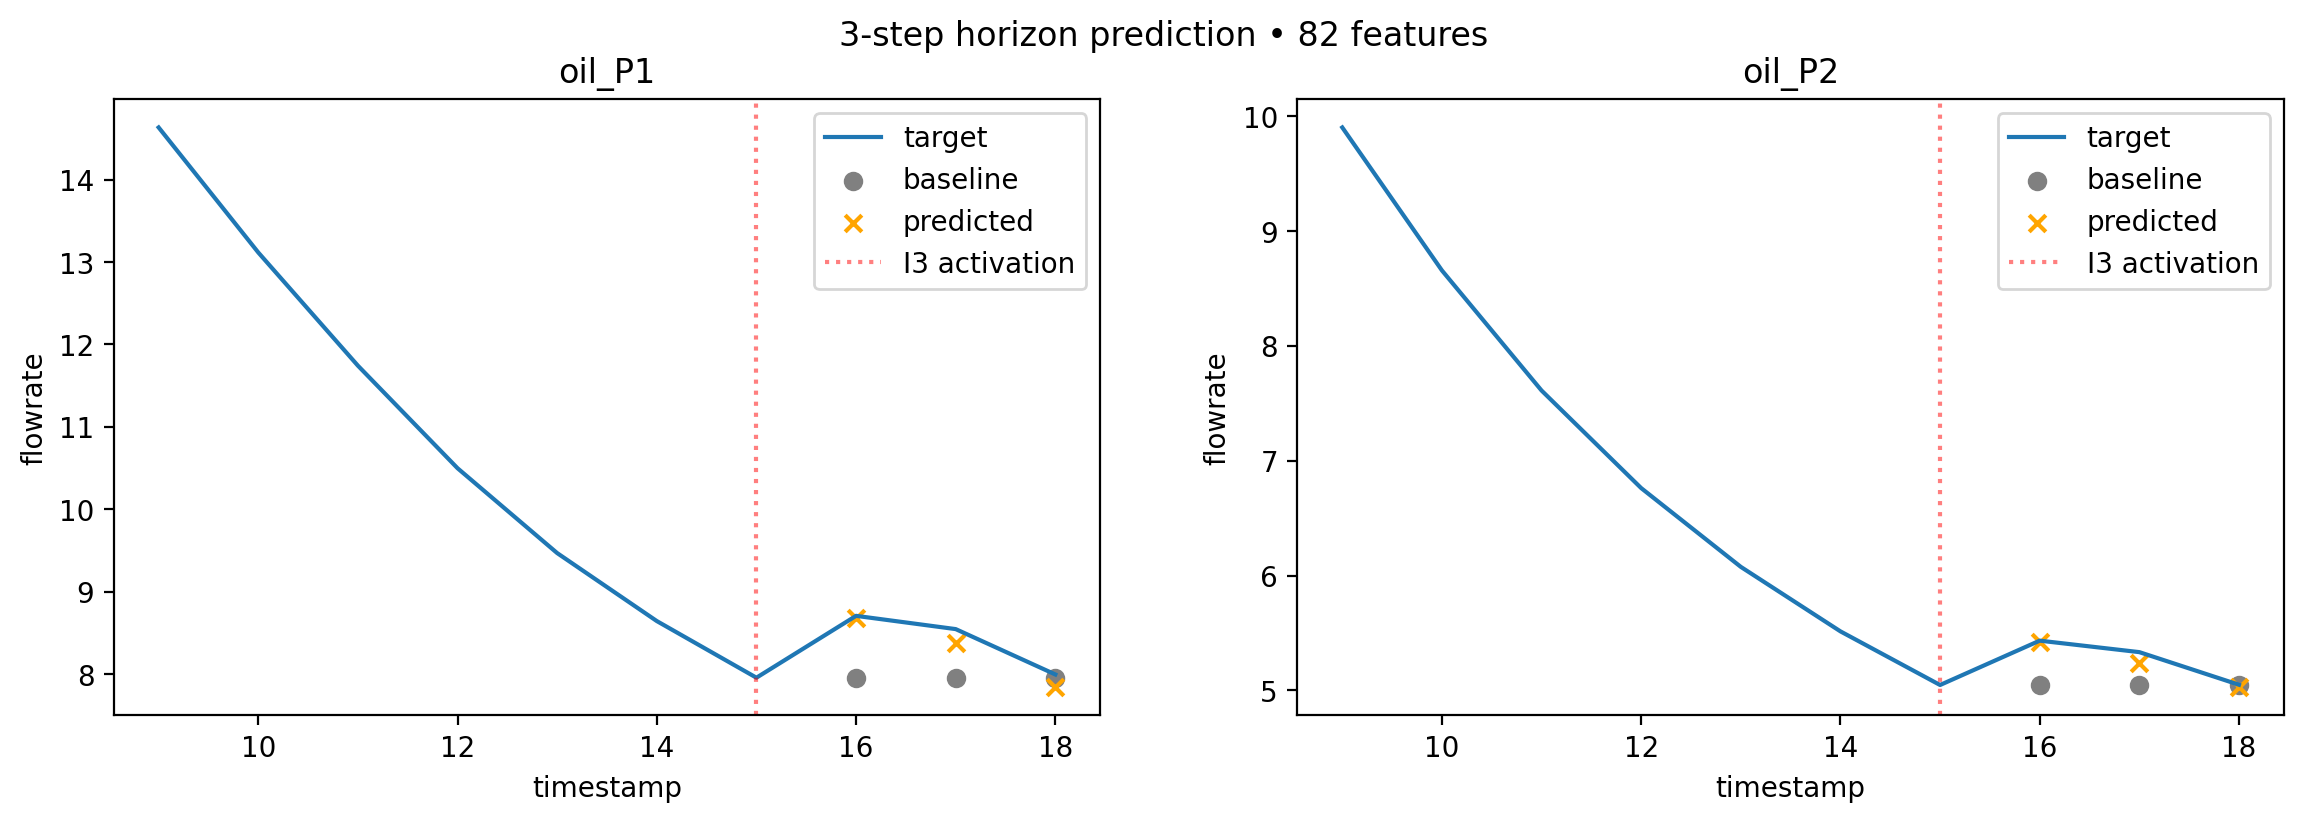

In [53]:
plot_multi(*predict_multi(lag, coef))

On the 3-step horizon, the model's performance also doesn't seem to get significantly worse.


### Statistical proof


Based on the graphs, it appears that the model outperforms the baseline, but, it is hard to tell for sure. We need a statistical test to determine whether the model's performance is indeed better than the baseline.


Given that we have a rolling window of 10 days, we will only be able to evaluate the model's performance on the data with the injector activation from a period no earlier than on the 10-th day.


In [54]:
combs_test = combs_test[combs_test[:, 0] > 9]

For each `start_lag` + `coef` combination from the test set, generate predictions within a 3-step horizon using both the model and the baseline:


In [55]:
predicted = np.array([])
baseline = np.array([])
truth = np.array([])

for comb in combs_test:
  results = predict_multi(*comb)
  for col in ["oil_P1", "oil_P2"]:
    predicted = np.concatenate([predicted, results[1][col]])
    baseline = np.concatenate([baseline, list(results[3][col]) * 3])
    truth = np.concatenate([truth, results[2].iloc[-3:][col]])

  plot_multi(*results)
  time.sleep(3)
  clear_output()

Compute the errors for each prediction and compare the two resulting distributions:


<Axes: title={'center': 'Model vs baseline errors'}>

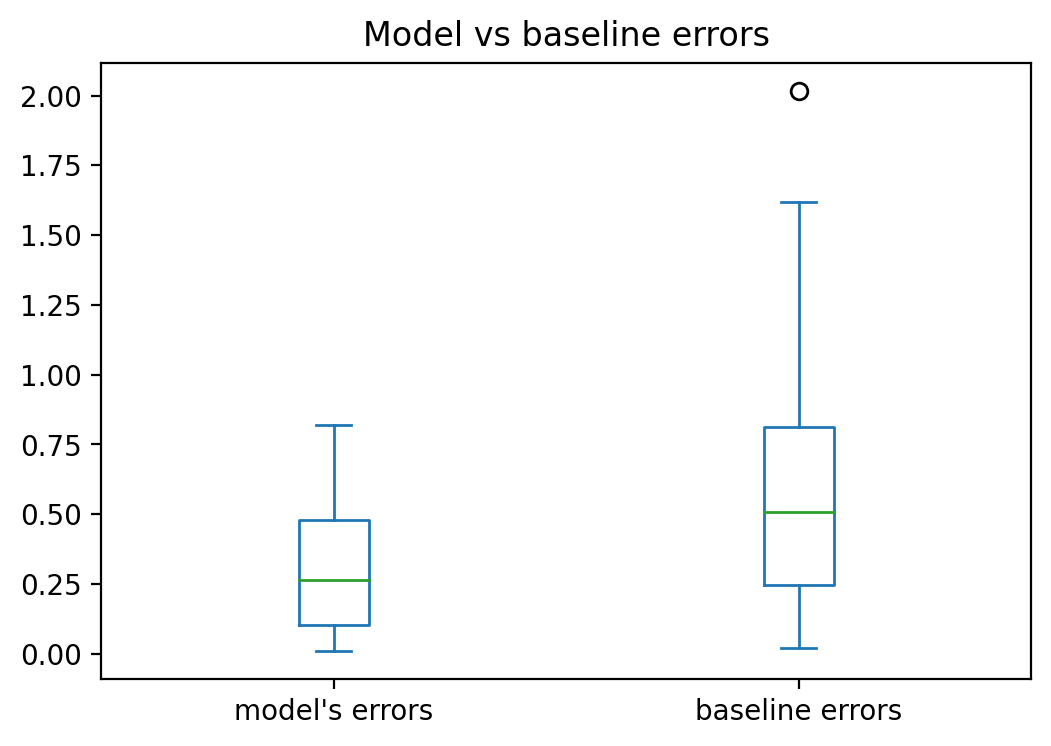

In [56]:
model_errors = np.abs(truth - predicted)
baseline_errors = np.abs(truth - baseline)

errors_df = pd.DataFrame(
    {"model's errors": model_errors, "baseline errors": baseline_errors}
)
errors_df.plot(kind="box", title="Model vs baseline errors", figsize=(6, 4))

The objective is to confirm that the average error of the model is in fact lower than that of the baseline. To do that, we will use the Barlett's test to compare the variances and then use one-sided Student's t-test to compare the means with the `equal_var` parameter specified according to the result of the previous test.

First, let's formulate the null hypothesis as follows:  
$H_o$ — The mean error of the model is not significantly different from the mean error of the baseline, i.e. the difference between the two means is not statistically significant.

Then the alternative will be:  
$H_1$ — The mean error of the model is significantly lower than the mean error of the baseline, i.e. the difference between the two means is statistically significant and the model performs better than the baseline.

To ensure the level of confidence, we'll use an alpha parameter of `0.001`.


In [57]:
# set the alpha parameter
alpha = 1e-3

# check for the variance similarity
bartlett_test = st.bartlett(model_errors, baseline_errors)

if bartlett_test.pvalue < alpha:
  equal_var = False
else:
  equal_var = True

# conduct the main test
t_test = st.ttest_ind(model_errors, baseline_errors, equal_var=equal_var)

if (t_test.pvalue < alpha) and (model_errors.mean() < baseline_errors.mean()):
  print(f"p-value:\t{t_test.pvalue}")
  print(
      "Reject Ho:\tModel's performance is indeed better than the baseline."
  )
else:
  print(f"p-value:\t{t_test.pvalue}")
  print(
      "Can't reject Ho:\tNot enough evidence to say that model outperforms the baseline."
  )

p-value:	9.597659326205997e-06
Reject Ho:	Model's performance is indeed better than the baseline.


---

## Conclusions


### Recap


Throughout this project, the following tasks have been completed:

- Rebuilt the initial dataset to a format suitable for regression modeling.
- Conducted exploratory data analysis to identify the key features for modeling.
- Enriched the data using feature engineering techniques such as lag-values and rolling statistics.
- Split the data into training, validation, and test sets; applied bootstrapping technique for increase the size of the training data and compensate for overfitting.
- Selected CatBoost as the modeling framework due to its built-in performance and functionality; used the last value repetition as the baseline.
- Achieved good model fit on the data using the range from 2 to 10-step lag features from and rolling mean and standard deviation features with the window sizes ranged from 2 to 10. Applied recursive method for 3-step horizon predictions, resulting in improved and visually distinct performance compared to the baseline.
- Conducted feature importance analysis, identifying the bottomhole pressure of the `I3` injector from the previous day and rolling statistics for the same well with the window size of 2 days as having the strongest predictive power for the model.
- Conducted feature selection and determined the most important features to be lags of 1, 2, 5, and 9 days, and rolling windows with sizes of 2, 3, 5, 6, 9, and 10.
- Used the student's t-test to verify that the model's average error is indeed less than that of the baseline.


### Results


- The reservoir system was modeled using the multiregression approach, incorporating the oil flowrate of production wells and the bottomhole pressure of injector wells as the key features.
- During the features importance analysis, it was discovered that the model uses a 1-day delayed `I3` injector parameters as the key predictor of impact on the system, with rolling window statistics for the same well also providing valuable predictive power.
- Feature selection techniques were employed to reduce the number of features from 142 to 82 without significant loss in performance.
- Lagged values of 1, 2, 5, and 9 days, along with rolling statistics with window sizes of 2, 3, 5, 6, 9, and 10 were identified as sufficient for robust modeling of the system.
- The model's performance was evaluated against the baseline using a hold-out sample, resulting in a 2-times reduction in mean absolute error. This finding was verified through statistical testing, and the significance of the improvement was confirmed.


### Drawbacks


The spatial data from the `meta.csv` file was not utilized in this project. The reason for this lies in the format in which the machine learning problem was defined. If we were making predictions from one well to another, knowledge of their spatial arrangement and other possible geostatistics would have been beneficial. However, since a multiregression format has been chosen, these parameters became constant values with no predictive value.

So why has the multiregresssion format been chosen? There were a few reasons:

1. It was not clear how to convert the initial data structure into a time series problem given 5 records per one timestamp. Therefore, it made sense to feed in all available information as one record, dropping all useless features on the way such as oil flowrate for injection wells and bottomhole pressure for the production wells.
2. Theoretically, model will be able to naturally account for spatial relationship in the data without us specifying it manually. However, the main drawback is that in this case we lose any chance to interpret this relationship.

Another major drawback is that due to the 10-day window sizes, the first 10 out of 30 timestamps had to be excluded from the data. As a result, the model's performance on the data with such parameters showed better results simply because it had less data to model. This issue also occurred during the final test on the hold-out set, as 9 out of 19 records had to be dropped for the same reason. After all, the question arises whether this small sample was adequate to prove the model's predictive ability.


### Space for improvements


1. To compensate for the small size of the dataset, we could employ several epochs of bootstrapping for the training sample paired with cross-validation and features selection to determine truly the most essential lag and rolling statistics values.

2. It would be intriguing to see how neural networks, particularly convolutional architectures, would be able to solve this problem. It seems plausible that such models could achieve a better fit with fewer lag features. However,in this case we can forget about interpretability.

3. There is a certain temptation to rewrite everything from scratch using the initial chained well-to-well data structure, properly utilizing spatial data available 🙂.
